In [4]:
import SimpleITK as sitk
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import cv2
from skimage import color
from skimage import io
import matplotlib.image as mpimg
import pandas as pd 
from sklearn.model_selection import train_test_split
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import glob
from skimage.io import imread
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.7.0


In [5]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [6]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [7]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


In [8]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [45]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)


In [60]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, train=False, test=False, extracted = False,
                 shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train = train
        self.test = test
        self.extracted = extracted
        self.image_paths, self.mask_paths = None, None
        self.get_data(db_dir, train, test)
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def get_data(self, root_dir, train, test):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        if self.extracted == True:
            self.image_paths = np.asarray(glob.glob(root_dir + "train_images/*.png"))
            self.mask_paths = np.asarray([path.replace('train_images', 'mask_images') for path in self.image_paths])
        elif self.train == True:
            self.image_paths = np.asarray(glob.glob(root_dir + "Train/train_images/*.png"))
            self.mask_paths = np.asarray([path.replace('Train/train_images', 'masks/mask_images') for path in self.image_paths])
        elif self.test == True:
            self.image_paths = np.asarray(glob.glob(root_dir + "Test/*.jpg.npy"))
            self.mask_paths = np.asarray([path.replace('Test', 'masks') for path in self.image_paths])
        else:
            self.mask_paths = np.asarray(glob.glob(root_dir + "masks/*.jpg.npy"))


    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        #mask_pathing = [mask_path.replace('.png', '.png.npy') for mask_path in self.mask_paths[batch_indices]]
      
        batch_x = np.asarray([cv2.imread(img_path).astype(np.float32)/255.0 for img_path in self.image_paths[batch_indices]])
        batch_y = np.asarray([cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) for mask_path in self.mask_paths[batch_indices]])
        return np.array(batch_x), np.array(batch_y[:len(batch_x)])
        #return None, None

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [11]:
input_shape = (128, 128, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [61]:
#train_data = getDataset(X_batch, Y_batch)
#test_data = getDataset(XT_batch, YT_batch)
train_data = DataGenerator('/content/', 10, extracted=True)
validation_data = DataGenerator('/content/drive/MyDrive/Licenta/Validation/', 10, train=True)

In [ ]:
/content/mask_images

In [62]:
x_batch, y_batch = train_data[0]
x_batch.shape

(10, 128, 128, 3)

In [63]:
model.compile(
    optimizer=Adam(1e-5),
    loss=dice_loss,
    metrics=["accuracy", dice_coef, iou]
)

In [64]:
model.fit(train_data, validation_data = validation_data, verbose=1, epochs=5)


Epoch 1/5
7515/7515 [==============================] - 1381s 183ms/step - loss: 1.3033e-06 - accuracy: 0.3995 - dice_coef: 1.3032e-06 - iou: 6.5168e-07 - val_loss: 9.6026e-09 - val_accuracy: 0.3357 - val_dice_coef: 9.6026e-09 - val_iou: 4.8013e-09
Epoch 2/5
7515/7515 [==============================] - 1315s 175ms/step - loss: 1.2038e-07 - accuracy: 0.3134 - dice_coef: 1.2038e-07 - iou: 6.0194e-08 - val_loss: 2.4625e-08 - val_accuracy: 0.3416 - val_dice_coef: 2.4625e-08 - val_iou: 1.2312e-08
Epoch 3/5
7515/7515 [==============================] - 1307s 174ms/step - loss: 4.8539e-08 - accuracy: 0.3189 - dice_coef: 4.8539e-08 - iou: 2.4270e-08 - val_loss: 3.3256e-09 - val_accuracy: 0.3375 - val_dice_coef: 3.3256e-09 - val_iou: 1.6628e-09
Epoch 4/5
7515/7515 [==============================] - 1307s 174ms/step - loss: 3.5740e-08 - accuracy: 0.3258 - dice_coef: 3.5740e-08 - iou: 1.7870e-08 - val_loss: 7.2495e-10 - val_accuracy: 0.3326 - val_dice_coef: 7.2495e-10 - val_iou: 3.6248e-10
Epoch 5/

In [71]:
x_test, y_test = validation_data[0]
preds = model.predict(x_test)

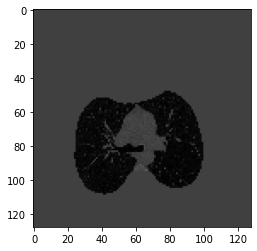

In [80]:
plt.imshow(x_test[5])

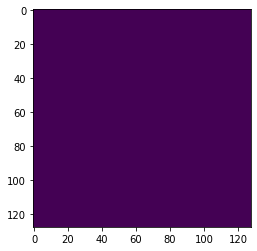

In [81]:
plt.imshow(y_test[5])

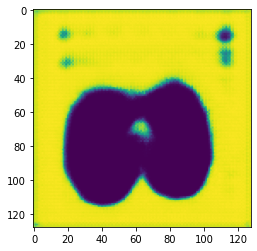

In [83]:
plt.imshow(np.reshape(preds[5],(128,128)))